## 0.1 Prepare Our Data for Kaggle

In [1]:
!pip install gdown

In [2]:
!gdown --id 1sE1mZZ5ZORgkIQSbhboQEmh0agYHi39m

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1sE1mZZ5ZORgkIQSbhboQEmh0agYHi39m
From (redirected): https://drive.google.com/uc?id=1sE1mZZ5ZORgkIQSbhboQEmh0agYHi39m&confirm=t&uuid=9c5f41af-7aa7-401c-b74b-b65e33457afe
To: /kaggle/working/Teeth_DataSet.zip
100%|██████████████████████████████████████| 49.1M/49.1M [00:00<00:00, 79.7MB/s]


In [52]:
import subprocess
import time
from tqdm import tqdm
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [4]:
def show_progress_bar():
    print("\nExtracting files... Please wait.")
    for _ in tqdm(range(100), desc="Progress", bar_format="{l_bar}{bar:50}{r_bar}", colour="cyan"):
        time.sleep(0.02)  # Simulate progress

# Run the unzip command silently
subprocess.run("unzip -q /kaggle/working/Teeth_DataSet.zip", shell=True)

# Show the fancy progress bar
show_progress_bar()

print("\n✅ Extraction complete! 🚀")

replace Teeth_Dataset/Testing/OC/oc_1239_0_6735.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)



Extracting files... Please wait.


Progress: 100%|██████████████████████████████████████████████████| 100/100 [00:02<00:00, 49.37it/s]


✅ Extraction complete! 🚀


## 0.2 📚 Importing Libraries and Loading Data 🧑‍💻

In [5]:
pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 88.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
from termcolor import colored
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights, resnet18
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import json
import onnx
import onnxruntime as ort

import torch
import numpy as np
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

# 🧪 Phase 1: Exploratory Data Study (EDS)
"Before building a smart model, we need to get smart about the data."

This phase helps us understand the structure, distribution, and balance of the dataset — the foundation of a solid ML project.

**🎯 EDS Goals:**
1.  Count the number of classes.
2.  Count the number of images in:
  * Training set
  * Validation set
  * Testing set
3.  Count the `number of samples` per class.
4.  Visualize class distribution

In [7]:
# Configuration
DATA_PATH = "/kaggle/working/Teeth_Dataset"
SPLITS = ["Training", "Validation", "Testing"]
VALID_EXTENSIONS = ('.png', '.jpg', '.jpeg')
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NPZ_DIR = "/kaggle/working/processed_data"
os.makedirs(NPZ_DIR, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 7
BATCH_SIZE = 32
EPOCHS = 20
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [8]:
DEVICE

device(type='cuda')

In [9]:
import shutil
import os

paths_to_delete = [
    "/kaggle/working/Teeth_Dataset/Testing/out",
    "/kaggle/working/Teeth_Dataset/Testing/output",
    "/kaggle/working/Teeth_Dataset/Testing/output_image.jpg",
    "/kaggle/working/Teeth_Dataset/Testing/outputs"
]

for path in paths_to_delete:
    if os.path.exists(path):
        if os.path.isdir(path):
            shutil.rmtree(path)
            print(f"🗑️ Deleted folder: {path}")
        else:
            os.remove(path)
            print(f"🗑️ Deleted file: {path}")
    else:
        print(f"⚠️ Not found: {path}")

🗑️ Deleted folder: /kaggle/working/Teeth_Dataset/Testing/out
🗑️ Deleted folder: /kaggle/working/Teeth_Dataset/Testing/output
🗑️ Deleted file: /kaggle/working/Teeth_Dataset/Testing/output_image.jpg
🗑️ Deleted folder: /kaggle/working/Teeth_Dataset/Testing/outputs


In [10]:
# Utility Functions
def get_class_counts(split_path):
    """Return a dictionary of class names and image counts in the given split."""
    class_counts = {}
    for class_name in sorted(os.listdir(split_path)):
        class_dir = os.path.join(split_path, class_name)
        if os.path.isdir(class_dir):
            count = len([f for f in os.listdir(class_dir) if f.lower().endswith(VALID_EXTENSIONS)])
            class_counts[class_name] = count
    return class_counts

In [11]:
def summarize_data_structure(base_path=DATA_PATH):
    """Return a summary dict of counts and classes in each dataset split."""
    summary = {}
    for split in SPLITS:
        split_path = os.path.join(base_path, split)
        class_counts = get_class_counts(split_path)
        total_images = sum(class_counts.values())
        summary[split] = {
            "num_classes": len(class_counts),
            "num_images": total_images,
            "class_counts": class_counts
        }
    return summary

In [12]:
def print_summary(summary):
    """Pretty-print the dataset summary and extract class names automatically."""
    print(colored("\n📊 DATASET SUMMARY:", "cyan", attrs=["bold", "underline"]))
    
    all_class_names = list(summary['Training']['class_counts'].keys())  # Extract from Training split
    print(colored(f"\n🔤 Detected Class Names:", "magenta", attrs=["bold"]))
    for i, class_name in enumerate(all_class_names):
        print(f"  {i}. {class_name}")

    for split in SPLITS:
        print(colored(f"\n📁 {split} Set", "yellow", attrs=["bold"]))
        print(colored(f"  ▸ Number of Classes: ", "white") + str(summary[split]['num_classes']))
        print(colored(f"  ▸ Total Images:     ", "white") + str(summary[split]['num_images']))
        
        if split == "Training":
            print(colored(f"  ▸ Class Breakdown:", "white"))
            for cls, count in summary[split]["class_counts"].items():
                print(f"     - {cls:15s}: {count} images")
    print(all_class_names)
    return all_class_names 


In [13]:
def visualize_class_distribution(class_counts, title="Class Distribution in Training Set"):
    """Plot class distribution using Plotly Express with a dark theme."""
    df = pd.DataFrame({
        "Class": list(class_counts.keys()),
        "Count": list(class_counts.values())
    }).sort_values("Count", ascending=False)
    
    fig = px.bar(df, x="Class", y="Count", text="Count", title=title,
                 template="plotly_dark", color="Class",
                 color_discrete_sequence=px.colors.qualitative.Vivid)
    
    fig.update_traces(textposition='outside')
    fig.update_layout(xaxis_title="Class", yaxis_title="Number of Images", title_font_size=24)
    fig.show()


In [14]:
# Main Runner
def run_eds():
    print(colored("🚀 Starting Phase 1: Exploratory Data Study...", "green", attrs=["bold"]))
    summary = summarize_data_structure(DATA_PATH)
    CLASS_NAMES = print_summary(summary)
    
    print(colored("\n📊 Generating class distribution plot for Training set...", "cyan"))
    visualize_class_distribution(summary["Training"]["class_counts"])
    return summary, CLASS_NAMES

In [15]:
summary, CLASS_NAMES = run_eds()

🚀 Starting Phase 1: Exploratory Data Study...

📊 DATASET SUMMARY:

🔤 Detected Class Names:
  0. CaS
  1. CoS
  2. Gum
  3. MC
  4. OC
  5. OLP
  6. OT

📁 Training Set
  ▸ Number of Classes: 7
  ▸ Total Images:     3087
  ▸ Class Breakdown:
     - CaS            : 480 images
     - CoS            : 450 images
     - Gum            : 360 images
     - MC             : 540 images
     - OC             : 324 images
     - OLP            : 540 images
     - OT             : 393 images

📁 Validation Set
  ▸ Number of Classes: 7
  ▸ Total Images:     1028

📁 Testing Set
  ▸ Number of Classes: 7
  ▸ Total Images:     1028
['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']

📊 Generating class distribution plot for Training set...


# 🧪 Phase 2: Preprocessing Pipeline Engineering (PPE)
In this phase, we’ll prepare the images to be model-ready by applying transformations that standardize, improve, and augment the dataset.

🎯 PPE Goals

|Step            |Description     |                Tools|
|----------------|----------------|---------------------|
|resize          |Unify Image size|`cv2`, `PIL`, `Keras`|
|Normalize       |Pixel values to range [0, 1] or mean-std|Tensor ops|
|Augment         |Add variation (flip, rotate, zoom, etc.)|`Albumentations` or `ImageDataGenerator`|
|Visualize       |Show original vs. augmented|`matplotlib` or `plotly`|
|Prepare pipeline|Save as a reusable function or generator|`ImageDataGenerator.flow_from_directory`|

In [16]:
def create_generators():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    plain_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_directory(
        os.path.join(DATA_PATH, "Training"),
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=True
    )

    val_gen = plain_datagen.flow_from_directory(
        os.path.join(DATA_PATH, "Validation"),
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False
    )

    test_gen = plain_datagen.flow_from_directory(
        os.path.join(DATA_PATH, "Testing"),
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False
    )

    return train_gen, val_gen, test_gen

In [53]:
def show_before_after_augmentation_from_dir(directory, image_size, aug_generator, class_indices, n=5):
    class_names = list(class_indices.keys())
    class_dir = random.choice(class_names)
    class_path = os.path.join(directory, class_dir)
    image_files = os.listdir(class_path)
    chosen_files = random.sample(image_files, n)

    fig, axes = plt.subplots(2, n, figsize=(4 * n, 6))
    fig.suptitle("🖼️ Before (Top) vs After (Bottom) Augmentation", fontsize=18)

    for i, file in enumerate(chosen_files):
        img_path = os.path.join(class_path, file)
        img = load_img(img_path, target_size=image_size)
        img_array = img_to_array(img) / 255.0

        # BEFORE
        axes[0, i].imshow(img_array)
        axes[0, i].axis('off')
        axes[0, i].set_title(f"{class_dir}")

        # AFTER (apply augmentation manually)
        aug_img = aug_generator.random_transform(img_array)
        axes[1, i].imshow(aug_img)
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

In [18]:
def save_npz_from_generator(generator, name="train"):
    x_list = []
    y_list = []

    print(colored(f"📦 Saving preprocessed {name} dataset to NPZ...", "green"))

    total = len(generator.filenames)
    steps = int(np.ceil(total / generator.batch_size))

    for i in range(steps):
        x_batch, y_batch = next(generator)
        x_list.append(x_batch)
        y_list.append(y_batch)

    x_all = np.concatenate(x_list)
    y_all = np.concatenate(y_list)

    np.savez_compressed(os.path.join(NPZ_DIR, f"{name}.npz"), images=x_all, labels=y_all)
    print(colored(f"✅ Saved {name}.npz with {x_all.shape[0]} samples.", "cyan"))

In [19]:
train_gen_aug, val_gen, test_gen = create_generators()

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [20]:
class_names = list(train_gen_aug.class_indices.keys())
print(colored(f"\n📚 Detected Classes: {class_names}", "magenta", attrs=["bold"]))


📚 Detected Classes: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


/tmp/ipykernel_35/489403426.py:26: UserWarning:

Glyph 128444 (\N{FRAME WITH PICTURE}) missing from current font.



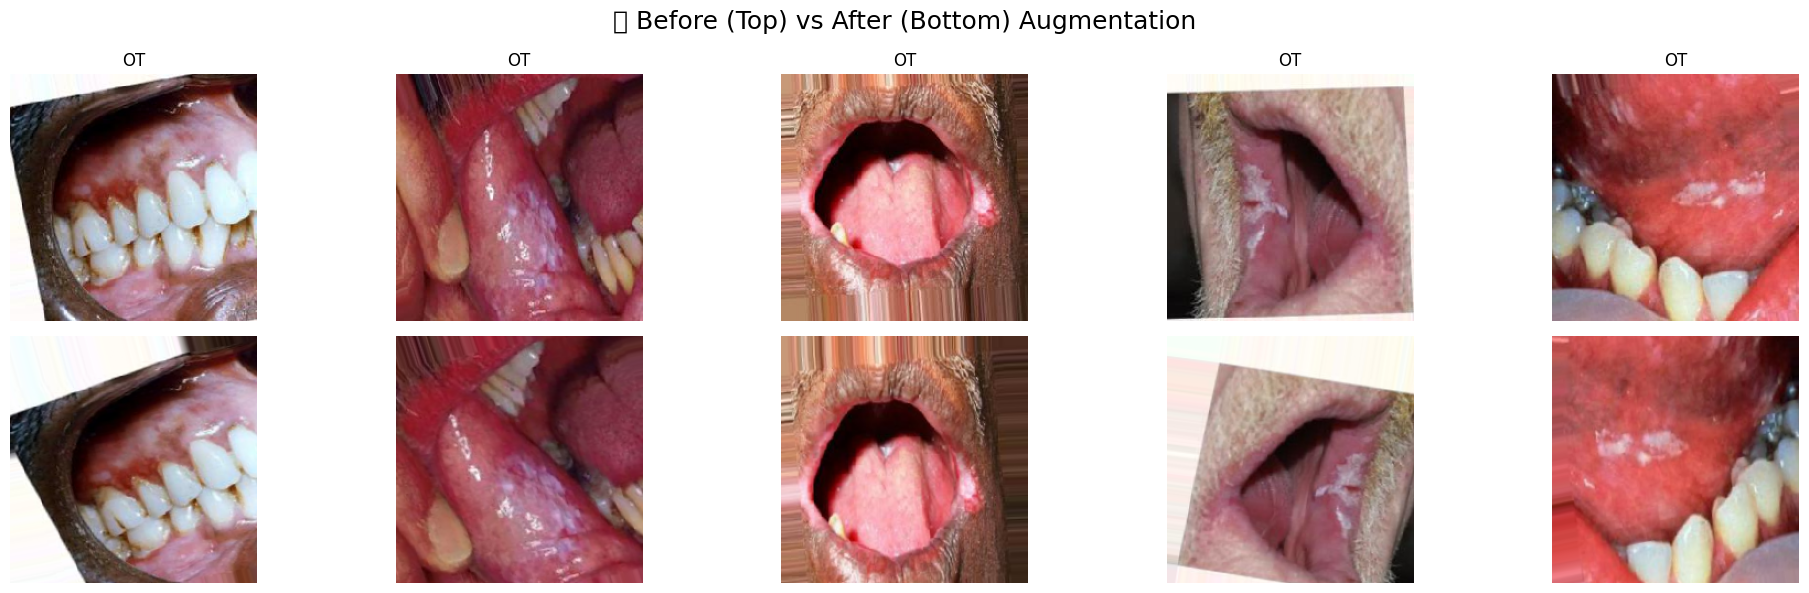

In [54]:
aug_gen_manual = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Show results
show_before_after_augmentation_from_dir(
    directory=os.path.join(DATA_PATH, "Training"),
    image_size=IMAGE_SIZE,
    aug_generator=aug_gen_manual,
    class_indices=train_gen_aug.class_indices,
    n=5
)


In [22]:
# Save all splits as .npz
save_npz_from_generator(train_gen_aug, name="train ")
save_npz_from_generator(val_gen, name="val")
save_npz_from_generator(test_gen, name="test")

📦 Saving preprocessed train  dataset to NPZ...
✅ Saved train .npz with 3087 samples.
📦 Saving preprocessed val dataset to NPZ...
✅ Saved val.npz with 1028 samples.
📦 Saving preprocessed test dataset to NPZ...
✅ Saved test.npz with 1028 samples.


 # 🧪Phase 3 – Model Building & Training (MBT)

 In this Phase we will try the following model Architectures:

|Model|Description|
|---------------------|--------------------|
|`BaseCNN`            |Custom CNN from scratch|
|`EfficientNetPretrained`|EfficientNetB0 with ImageNet weights|
|`EfficientNetScratch`|EfficientNetB0 from scratch|
|`ResNet18Pretrained`|Classic ResNet18 pretrained|
|`ResNet18Scratch`|ResNet18 from scratch|


## 3.1 Build the models

### 3.1.1 BaseCNN Model

In [23]:
class BaseCNN(nn.Module):
    """🧠 Simple CNN built from scratch with dynamic FC input size."""
    def __init__(self, num_classes):
        super(BaseCNN, self).__init__()
        self.model_name = "BaseCNN"
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # 224x224
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 112x112
            nn.Conv2d(32, 64, kernel_size=3),  # -> 110x110
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # -> 55x55
        )

        # Dynamically compute the flattened size
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 224, 224)
            flat_size = self.features(dummy).view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

### 3.1.2 EfficientNetPretrained 

In [24]:
class EfficientNetPretrained(nn.Module):
    """🚀 EfficientNetB0 pretrained."""
    def __init__(self, num_classes):
        super(EfficientNetPretrained, self).__init__()
        self.model_name = "EfficientNetB0 (Pretrained)"
        self.base = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        self.base.classifier[1] = nn.Linear(self.base.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.base(x)

### 3.1.3 EfficientNetScratch

In [25]:
class EfficientNetScratch(nn.Module):
    """🧱 EfficientNetB0 from scratch."""
    def __init__(self, num_classes):
        super(EfficientNetScratch, self).__init__()
        self.model_name = "EfficientNetB0 (Scratch)"
        self.base = efficientnet_b0(weights=None)
        self.base.classifier[1] = nn.Linear(self.base.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.base(x)

### 3.1.4 ResNet18Pretrained

In [26]:
class ResNet18Pretrained(nn.Module):
    """🌀 ResNet18 pretrained."""
    def __init__(self, num_classes):
        super(ResNet18Pretrained, self).__init__()
        self.model_name = "ResNet18 (Pretrained)"
        self.base = resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.base.fc = nn.Linear(self.base.fc.in_features, num_classes)

    def forward(self, x):
        return self.base(x)

### 3.1.5 ResNet18Scratch

In [27]:
class ResNet18Scratch(nn.Module):
    """🧩 ResNet18 from scratch."""
    def __init__(self, num_classes):
        super(ResNet18Scratch, self).__init__()
        self.model_name = "ResNet18 (Scratch)"
        self.base = resnet18(weights=None)
        self.base.fc = nn.Linear(self.base.fc.in_features, num_classes)

    def forward(self, x):
        return self.base(x)

### 3.1.6 Call the models

In [28]:
MODEL_CLASSES = [
    BaseCNN,
    EfficientNetPretrained,
    EfficientNetScratch,
    ResNet18Pretrained,
    ResNet18Scratch,
]

## 3.2 LOAD DATA 

In [29]:
def load_npz_to_loader(npz_path):
    data = np.load(npz_path)
    x_tensor = torch.tensor(data['images'], dtype=torch.float32).permute(0, 3, 1, 2)
    y_tensor = torch.tensor(data['labels'], dtype=torch.float32)
    dataset = TensorDataset(x_tensor, y_tensor)
    return DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

train_loader = load_npz_to_loader("/kaggle/working/processed_data/train .npz")
val_loader = load_npz_to_loader("/kaggle/working/processed_data/val.npz")
test_loader = load_npz_to_loader("/kaggle/working/processed_data/test.npz")

## 3.3 Train the models

In [30]:
from termcolor import colored

def train_one_model(ModelClass):
    model = ModelClass(NUM_CLASSES).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    train_start = time.time()
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    best_val_loss = float('inf')

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0
        correct_train = 0
        total_train = 0

        loop = tqdm(train_loader, desc=f"{model.model_name} - Epoch {epoch+1}/{EPOCHS}", leave=False)

        for inputs, targets in loop:
            inputs, targets = inputs.to(DEVICE), torch.argmax(targets, dim=1).to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == targets).sum().item()
            total_train += targets.size(0)

            loop.set_postfix({
                "Loss": f"{loss.item():.4f}",
                "Acc": f"{100 * correct_train / total_train:.2f}%"
            })

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # Validation
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(DEVICE), torch.argmax(targets, dim=1).to(DEVICE)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == targets).sum().item()
                total_val += targets.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_accuracy)
        history['val_acc'].append(val_accuracy)

        # Print Epoch Summary
        print(colored(f"\n📘 Epoch {epoch+1}/{EPOCHS} Summary for {model.model_name}", "cyan", attrs=["bold"]))
        print(colored(f"  🏋️ Train Loss: {avg_train_loss:.4f} | Accuracy: {train_accuracy*100:.2f}%", "green"))
        print(colored(f"  🧪 Val   Loss: {avg_val_loss:.4f} | Accuracy: {val_accuracy*100:.2f}%", "yellow"))

        if avg_val_loss > best_val_loss:
            print(colored("  ⚠️ Warning: Validation loss increased — possible overfitting!", "red"))
        else:
            best_val_loss = avg_val_loss

    train_time = time.time() - train_start
    return model, history, train_time


In [31]:
def evaluate_model(model):
    model.eval()
    correct, total = 0, 0
    inference_start = time.time()
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(DEVICE), torch.argmax(targets, dim=1).to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    inference_time = time.time() - inference_start
    accuracy = correct / total
    return accuracy, inference_time

In [32]:
def save_model_variants(model, model_name):
    torch.save(model.state_dict(), f"{RESULTS_DIR}/{model_name}.pt")
    dummy_input = torch.randn(1, 3, 224, 224).to(DEVICE)
    torch.onnx.export(model, dummy_input, f"{RESULTS_DIR}/{model_name}.onnx", 
                      input_names=['input'], output_names=['output'], 
                      dynamic_axes={'input': {0: 'batch'}, 'output': {0: 'batch'}}, 
                      export_params=True)
    print(f"✅ Saved {model_name} in .pt and .onnx format")

In [33]:
results = []
for ModelClass in MODEL_CLASSES:
    model = None
    model, history, train_time = train_one_model(ModelClass)
    acc, inference_time = evaluate_model(model)
    model_name = model.model_name.replace(" ", "_").replace("(", "").replace(")", "")

    save_model_variants(model, model_name)

    # Save history
    with open(f"{RESULTS_DIR}/{model_name}_history.json", "w") as f:
        json.dump(history, f, indent=2)

    # Summary row
    results.append({
        "Model": model.model_name,
        "Train Time (s)": round(train_time, 2),
        "Inference Time (s)": round(inference_time, 2),
        "Test Accuracy": round(acc * 100, 2),
        "Model Path": f"{model_name}.pt"
    })

# ---------- RESULTS CSV ----------
pd.DataFrame(results).to_csv(f"{RESULTS_DIR}/model_comparison.csv", index=False)
print("\n🏁 All models trained and evaluated! Summary saved to model_comparison.csv")


📘 Epoch 1/20 Summary for BaseCNN
  🏋️ Train Loss: 1.9132 | Accuracy: 21.83%
  🧪 Val   Loss: 1.8114 | Accuracy: 26.75%



📘 Epoch 2/20 Summary for BaseCNN
  🏋️ Train Loss: 1.8031 | Accuracy: 26.89%
  🧪 Val   Loss: 1.7134 | Accuracy: 33.75%



📘 Epoch 3/20 Summary for BaseCNN
  🏋️ Train Loss: 1.7160 | Accuracy: 33.24%
  🧪 Val   Loss: 1.6302 | Accuracy: 39.11%



📘 Epoch 4/20 Summary for BaseCNN
  🏋️ Train Loss: 1.6304 | Accuracy: 37.29%
  🧪 Val   Loss: 1.5414 | Accuracy: 42.22%



📘 Epoch 5/20 Summary for BaseCNN
  🏋️ Train Loss: 1.5645 | Accuracy: 40.14%
  🧪 Val   Loss: 1.4873 | Accuracy: 46.40%



📘 Epoch 6/20 Summary for BaseCNN
  🏋️ Train Loss: 1.4984 | Accuracy: 43.02%
  🧪 Val   Loss: 1.4087 | Accuracy: 48.54%



📘 Epoch 7/20 Summary for BaseCNN
  🏋️ Train Loss: 1.4234 | Accuracy: 46.58%
  🧪 Val   Loss: 1.3863 | Accuracy: 50.29%



📘 Epoch 8/20 Summary for BaseCNN
  🏋️ Train Loss: 1.3512 | Accuracy: 49.66%
  🧪 Val   Loss: 1.3132 | Accuracy: 52.72%



📘 Epoch 9/20 Summary for BaseCNN
  🏋️ Train Loss: 1.2943 | Accuracy: 50.73%
  🧪 Val   Loss: 1.2375 | Accuracy: 53.89%



📘 Epoch 10/20 Summary for BaseCNN
  🏋️ Train Loss: 1.2105 | Accuracy: 55.23%
  🧪 Val   Loss: 1.2592 | Accuracy: 53.50%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 11/20 Summary for BaseCNN
  🏋️ Train Loss: 1.1706 | Accuracy: 57.14%
  🧪 Val   Loss: 1.2336 | Accuracy: 52.72%



📘 Epoch 12/20 Summary for BaseCNN
  🏋️ Train Loss: 1.1303 | Accuracy: 59.22%
  🧪 Val   Loss: 1.1822 | Accuracy: 55.54%



📘 Epoch 13/20 Summary for BaseCNN
  🏋️ Train Loss: 1.0644 | Accuracy: 61.42%
  🧪 Val   Loss: 1.2788 | Accuracy: 52.24%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 14/20 Summary for BaseCNN
  🏋️ Train Loss: 1.0169 | Accuracy: 63.59%
  🧪 Val   Loss: 1.1714 | Accuracy: 58.46%



📘 Epoch 15/20 Summary for BaseCNN
  🏋️ Train Loss: 0.9768 | Accuracy: 65.53%
  🧪 Val   Loss: 1.1403 | Accuracy: 58.17%



📘 Epoch 16/20 Summary for BaseCNN
  🏋️ Train Loss: 0.9188 | Accuracy: 67.64%
  🧪 Val   Loss: 1.1164 | Accuracy: 57.00%



📘 Epoch 17/20 Summary for BaseCNN
  🏋️ Train Loss: 0.8450 | Accuracy: 70.36%
  🧪 Val   Loss: 1.1179 | Accuracy: 57.20%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 18/20 Summary for BaseCNN
  🏋️ Train Loss: 0.8303 | Accuracy: 70.81%
  🧪 Val   Loss: 1.0989 | Accuracy: 58.27%



📘 Epoch 19/20 Summary for BaseCNN
  🏋️ Train Loss: 0.7793 | Accuracy: 72.66%
  🧪 Val   Loss: 1.1489 | Accuracy: 56.81%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 20/20 Summary for BaseCNN
  🏋️ Train Loss: 0.7345 | Accuracy: 74.38%
  🧪 Val   Loss: 1.0972 | Accuracy: 58.75%
✅ Saved BaseCNN in .pt and .onnx format


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 134MB/s] 



📘 Epoch 1/20 Summary for EfficientNetB0 (Pretrained)
  🏋️ Train Loss: 1.4083 | Accuracy: 55.62%
  🧪 Val   Loss: 0.7350 | Accuracy: 78.89%



📘 Epoch 2/20 Summary for EfficientNetB0 (Pretrained)
  🏋️ Train Loss: 0.5367 | Accuracy: 85.07%
  🧪 Val   Loss: 0.2487 | Accuracy: 94.16%



📘 Epoch 3/20 Summary for EfficientNetB0 (Pretrained)
  🏋️ Train Loss: 0.1867 | Accuracy: 95.76%
  🧪 Val   Loss: 0.0949 | Accuracy: 98.35%



📘 Epoch 4/20 Summary for EfficientNetB0 (Pretrained)
  🏋️ Train Loss: 0.0825 | Accuracy: 98.51%
  🧪 Val   Loss: 0.0472 | Accuracy: 99.03%



📘 Epoch 5/20 Summary for EfficientNetB0 (Pretrained)
  🏋️ Train Loss: 0.0542 | Accuracy: 98.90%
  🧪 Val   Loss: 0.0387 | Accuracy: 99.32%



📘 Epoch 6/20 Summary for EfficientNetB0 (Pretrained)
  🏋️ Train Loss: 0.0452 | Accuracy: 98.96%
  🧪 Val   Loss: 0.0299 | Accuracy: 99.32%



📘 Epoch 7/20 Summary for EfficientNetB0 (Pretrained)
  🏋️ Train Loss: 0.0368 | Accuracy: 99.13%
  🧪 Val   Loss: 0.0226 | Accuracy: 99.22%



📘 Epoch 8/20 Summary for EfficientNetB0 (Pretrained)
  🏋️ Train Loss: 0.0235 | Accuracy: 99.55%
  🧪 Val   Loss: 0.0241 | Accuracy: 99.51%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 9/20 Summary for EfficientNetB0 (Pretrained)
  🏋️ Train Loss: 0.0206 | Accuracy: 99.55%
  🧪 Val   Loss: 0.0236 | Accuracy: 99.51%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 10/20 Summary for EfficientNetB0 (Pretrained)
  🏋️ Train Loss: 0.0175 | Accuracy: 99.55%
  🧪 Val   Loss: 0.0263 | Accuracy: 99.32%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 11/20 Summary for EfficientNetB0 (Pretrained)
  🏋️ Train Loss: 0.0159 | Accuracy: 99.84%
  🧪 Val   Loss: 0.0192 | Accuracy: 99.42%



📘 Epoch 12/20 Summary for EfficientNetB0 (Pretrained)
  🏋️ Train Loss: 0.0150 | Accuracy: 99.64%
  🧪 Val   Loss: 0.0211 | Accuracy: 99.71%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 13/20 Summary for EfficientNetB0 (Pretrained)
  🏋️ Train Loss: 0.0147 | Accuracy: 99.55%
  🧪 Val   Loss: 0.0494 | Accuracy: 99.12%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 14/20 Summary for EfficientNetB0 (Pretrained)
  🏋️ Train Loss: 0.0129 | Accuracy: 99.74%
  🧪 Val   Loss: 0.0142 | Accuracy: 99.71%



📘 Epoch 15/20 Summary for EfficientNetB0 (Pretrained)
  🏋️ Train Loss: 0.0127 | Accuracy: 99.68%
  🧪 Val   Loss: 0.0173 | Accuracy: 99.61%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 16/20 Summary for EfficientNetB0 (Pretrained)
  🏋️ Train Loss: 0.0093 | Accuracy: 99.81%
  🧪 Val   Loss: 0.0169 | Accuracy: 99.71%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 17/20 Summary for EfficientNetB0 (Pretrained)
  🏋️ Train Loss: 0.0082 | Accuracy: 99.81%
  🧪 Val   Loss: 0.0125 | Accuracy: 99.61%



📘 Epoch 18/20 Summary for EfficientNetB0 (Pretrained)
  🏋️ Train Loss: 0.0097 | Accuracy: 99.68%
  🧪 Val   Loss: 0.0152 | Accuracy: 99.32%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 19/20 Summary for EfficientNetB0 (Pretrained)
  🏋️ Train Loss: 0.0078 | Accuracy: 99.84%
  🧪 Val   Loss: 0.0203 | Accuracy: 99.51%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 20/20 Summary for EfficientNetB0 (Pretrained)
  🏋️ Train Loss: 0.0103 | Accuracy: 99.64%
  🧪 Val   Loss: 0.0109 | Accuracy: 99.81%
✅ Saved EfficientNetB0_Pretrained in .pt and .onnx format



📘 Epoch 1/20 Summary for EfficientNetB0 (Scratch)
  🏋️ Train Loss: 1.8911 | Accuracy: 21.15%
  🧪 Val   Loss: 1.8269 | Accuracy: 23.15%



📘 Epoch 2/20 Summary for EfficientNetB0 (Scratch)
  🏋️ Train Loss: 1.7415 | Accuracy: 29.48%
  🧪 Val   Loss: 1.7051 | Accuracy: 31.61%



📘 Epoch 3/20 Summary for EfficientNetB0 (Scratch)
  🏋️ Train Loss: 1.6007 | Accuracy: 37.32%
  🧪 Val   Loss: 1.5638 | Accuracy: 39.11%



📘 Epoch 4/20 Summary for EfficientNetB0 (Scratch)
  🏋️ Train Loss: 1.4830 | Accuracy: 43.18%
  🧪 Val   Loss: 1.4493 | Accuracy: 42.41%



📘 Epoch 5/20 Summary for EfficientNetB0 (Scratch)
  🏋️ Train Loss: 1.3146 | Accuracy: 49.95%
  🧪 Val   Loss: 1.4737 | Accuracy: 44.26%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 6/20 Summary for EfficientNetB0 (Scratch)
  🏋️ Train Loss: 1.1415 | Accuracy: 57.56%
  🧪 Val   Loss: 1.4570 | Accuracy: 48.35%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 7/20 Summary for EfficientNetB0 (Scratch)
  🏋️ Train Loss: 0.9685 | Accuracy: 65.66%
  🧪 Val   Loss: 1.5262 | Accuracy: 49.32%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 8/20 Summary for EfficientNetB0 (Scratch)
  🏋️ Train Loss: 0.8231 | Accuracy: 71.07%
  🧪 Val   Loss: 1.6757 | Accuracy: 48.74%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 9/20 Summary for EfficientNetB0 (Scratch)
  🏋️ Train Loss: 0.6914 | Accuracy: 76.64%
  🧪 Val   Loss: 1.7433 | Accuracy: 49.42%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 10/20 Summary for EfficientNetB0 (Scratch)
  🏋️ Train Loss: 0.6015 | Accuracy: 79.56%
  🧪 Val   Loss: 1.7452 | Accuracy: 47.47%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 11/20 Summary for EfficientNetB0 (Scratch)
  🏋️ Train Loss: 0.5379 | Accuracy: 82.02%
  🧪 Val   Loss: 1.8307 | Accuracy: 50.19%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 12/20 Summary for EfficientNetB0 (Scratch)
  🏋️ Train Loss: 0.4741 | Accuracy: 84.00%
  🧪 Val   Loss: 1.9309 | Accuracy: 49.03%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 13/20 Summary for EfficientNetB0 (Scratch)
  🏋️ Train Loss: 0.4463 | Accuracy: 85.46%
  🧪 Val   Loss: 1.7697 | Accuracy: 51.56%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 14/20 Summary for EfficientNetB0 (Scratch)
  🏋️ Train Loss: 0.3955 | Accuracy: 87.24%
  🧪 Val   Loss: 1.8158 | Accuracy: 53.89%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 15/20 Summary for EfficientNetB0 (Scratch)
  🏋️ Train Loss: 0.3816 | Accuracy: 87.59%
  🧪 Val   Loss: 1.8234 | Accuracy: 51.56%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 16/20 Summary for EfficientNetB0 (Scratch)
  🏋️ Train Loss: 0.3469 | Accuracy: 88.37%
  🧪 Val   Loss: 1.7878 | Accuracy: 54.96%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 17/20 Summary for EfficientNetB0 (Scratch)
  🏋️ Train Loss: 0.3148 | Accuracy: 89.25%
  🧪 Val   Loss: 2.2644 | Accuracy: 46.98%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 18/20 Summary for EfficientNetB0 (Scratch)
  🏋️ Train Loss: 0.3458 | Accuracy: 88.37%
  🧪 Val   Loss: 1.8518 | Accuracy: 53.70%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 19/20 Summary for EfficientNetB0 (Scratch)
  🏋️ Train Loss: 0.2935 | Accuracy: 90.22%
  🧪 Val   Loss: 1.9260 | Accuracy: 51.85%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 20/20 Summary for EfficientNetB0 (Scratch)
  🏋️ Train Loss: 0.2553 | Accuracy: 90.99%
  🧪 Val   Loss: 1.7036 | Accuracy: 54.57%
  ⚠️ Warning: Validation loss increased — possible overfitting!
✅ Saved EfficientNetB0_Scratch in .pt and .onnx format


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s] 



📘 Epoch 1/20 Summary for ResNet18 (Pretrained)
  🏋️ Train Loss: 0.8353 | Accuracy: 71.88%
  🧪 Val   Loss: 0.2993 | Accuracy: 92.70%



📘 Epoch 2/20 Summary for ResNet18 (Pretrained)
  🏋️ Train Loss: 0.1065 | Accuracy: 98.61%
  🧪 Val   Loss: 0.1045 | Accuracy: 97.57%



📘 Epoch 3/20 Summary for ResNet18 (Pretrained)
  🏋️ Train Loss: 0.0293 | Accuracy: 99.77%
  🧪 Val   Loss: 0.0993 | Accuracy: 97.76%



📘 Epoch 4/20 Summary for ResNet18 (Pretrained)
  🏋️ Train Loss: 0.0125 | Accuracy: 99.94%
  🧪 Val   Loss: 0.0651 | Accuracy: 98.15%



📘 Epoch 5/20 Summary for ResNet18 (Pretrained)
  🏋️ Train Loss: 0.0075 | Accuracy: 100.00%
  🧪 Val   Loss: 0.0697 | Accuracy: 98.35%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 6/20 Summary for ResNet18 (Pretrained)
  🏋️ Train Loss: 0.0055 | Accuracy: 100.00%
  🧪 Val   Loss: 0.0583 | Accuracy: 98.25%



📘 Epoch 7/20 Summary for ResNet18 (Pretrained)
  🏋️ Train Loss: 0.0051 | Accuracy: 100.00%
  🧪 Val   Loss: 0.0540 | Accuracy: 98.15%



📘 Epoch 8/20 Summary for ResNet18 (Pretrained)
  🏋️ Train Loss: 0.0034 | Accuracy: 100.00%
  🧪 Val   Loss: 0.0754 | Accuracy: 98.05%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 9/20 Summary for ResNet18 (Pretrained)
  🏋️ Train Loss: 0.0034 | Accuracy: 99.97%
  🧪 Val   Loss: 0.0492 | Accuracy: 98.83%



📘 Epoch 10/20 Summary for ResNet18 (Pretrained)
  🏋️ Train Loss: 0.0025 | Accuracy: 100.00%
  🧪 Val   Loss: 0.0667 | Accuracy: 98.44%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 11/20 Summary for ResNet18 (Pretrained)
  🏋️ Train Loss: 0.0017 | Accuracy: 100.00%
  🧪 Val   Loss: 0.0454 | Accuracy: 98.54%



📘 Epoch 12/20 Summary for ResNet18 (Pretrained)
  🏋️ Train Loss: 0.0017 | Accuracy: 100.00%
  🧪 Val   Loss: 0.0507 | Accuracy: 98.54%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 13/20 Summary for ResNet18 (Pretrained)
  🏋️ Train Loss: 0.0016 | Accuracy: 100.00%
  🧪 Val   Loss: 0.0453 | Accuracy: 98.35%



📘 Epoch 14/20 Summary for ResNet18 (Pretrained)
  🏋️ Train Loss: 0.0015 | Accuracy: 100.00%
  🧪 Val   Loss: 0.0477 | Accuracy: 98.44%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 15/20 Summary for ResNet18 (Pretrained)
  🏋️ Train Loss: 0.0013 | Accuracy: 100.00%
  🧪 Val   Loss: 0.0491 | Accuracy: 98.93%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 16/20 Summary for ResNet18 (Pretrained)
  🏋️ Train Loss: 0.0009 | Accuracy: 100.00%
  🧪 Val   Loss: 0.0468 | Accuracy: 98.54%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 17/20 Summary for ResNet18 (Pretrained)
  🏋️ Train Loss: 0.0007 | Accuracy: 100.00%
  🧪 Val   Loss: 0.0419 | Accuracy: 98.74%



📘 Epoch 18/20 Summary for ResNet18 (Pretrained)
  🏋️ Train Loss: 0.0010 | Accuracy: 100.00%
  🧪 Val   Loss: 0.0572 | Accuracy: 98.54%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 19/20 Summary for ResNet18 (Pretrained)
  🏋️ Train Loss: 0.0007 | Accuracy: 100.00%
  🧪 Val   Loss: 0.0416 | Accuracy: 98.44%



📘 Epoch 20/20 Summary for ResNet18 (Pretrained)
  🏋️ Train Loss: 0.0008 | Accuracy: 100.00%
  🧪 Val   Loss: 0.0562 | Accuracy: 98.74%
  ⚠️ Warning: Validation loss increased — possible overfitting!
✅ Saved ResNet18_Pretrained in .pt and .onnx format



📘 Epoch 1/20 Summary for ResNet18 (Scratch)
  🏋️ Train Loss: 1.5734 | Accuracy: 37.80%
  🧪 Val   Loss: 1.7684 | Accuracy: 41.73%



📘 Epoch 2/20 Summary for ResNet18 (Scratch)
  🏋️ Train Loss: 1.2004 | Accuracy: 55.69%
  🧪 Val   Loss: 1.6496 | Accuracy: 49.42%



📘 Epoch 3/20 Summary for ResNet18 (Scratch)
  🏋️ Train Loss: 0.8375 | Accuracy: 70.17%
  🧪 Val   Loss: 1.5726 | Accuracy: 50.10%



📘 Epoch 4/20 Summary for ResNet18 (Scratch)
  🏋️ Train Loss: 0.5293 | Accuracy: 81.96%
  🧪 Val   Loss: 1.0929 | Accuracy: 60.41%



📘 Epoch 5/20 Summary for ResNet18 (Scratch)
  🏋️ Train Loss: 0.2586 | Accuracy: 93.00%
  🧪 Val   Loss: 0.9222 | Accuracy: 68.58%



📘 Epoch 6/20 Summary for ResNet18 (Scratch)
  🏋️ Train Loss: 0.1427 | Accuracy: 96.70%
  🧪 Val   Loss: 1.1898 | Accuracy: 64.20%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 7/20 Summary for ResNet18 (Scratch)
  🏋️ Train Loss: 0.1019 | Accuracy: 97.76%
  🧪 Val   Loss: 1.6138 | Accuracy: 56.42%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 8/20 Summary for ResNet18 (Scratch)
  🏋️ Train Loss: 0.0709 | Accuracy: 98.15%
  🧪 Val   Loss: 1.1682 | Accuracy: 65.18%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 9/20 Summary for ResNet18 (Scratch)
  🏋️ Train Loss: 0.0407 | Accuracy: 99.48%
  🧪 Val   Loss: 0.7508 | Accuracy: 71.50%



📘 Epoch 10/20 Summary for ResNet18 (Scratch)
  🏋️ Train Loss: 0.0389 | Accuracy: 99.45%
  🧪 Val   Loss: 1.1065 | Accuracy: 65.66%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 11/20 Summary for ResNet18 (Scratch)
  🏋️ Train Loss: 0.0249 | Accuracy: 99.68%
  🧪 Val   Loss: 1.5183 | Accuracy: 56.91%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 12/20 Summary for ResNet18 (Scratch)
  🏋️ Train Loss: 0.0164 | Accuracy: 99.90%
  🧪 Val   Loss: 0.6923 | Accuracy: 77.43%



📘 Epoch 13/20 Summary for ResNet18 (Scratch)
  🏋️ Train Loss: 0.0116 | Accuracy: 99.87%
  🧪 Val   Loss: 0.9816 | Accuracy: 69.46%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 14/20 Summary for ResNet18 (Scratch)
  🏋️ Train Loss: 0.0320 | Accuracy: 99.25%
  🧪 Val   Loss: 0.9778 | Accuracy: 67.80%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 15/20 Summary for ResNet18 (Scratch)
  🏋️ Train Loss: 0.0923 | Accuracy: 97.02%
  🧪 Val   Loss: 5.3918 | Accuracy: 34.44%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 16/20 Summary for ResNet18 (Scratch)
  🏋️ Train Loss: 0.3428 | Accuracy: 88.66%
  🧪 Val   Loss: 2.0159 | Accuracy: 49.51%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 17/20 Summary for ResNet18 (Scratch)
  🏋️ Train Loss: 0.1489 | Accuracy: 95.43%
  🧪 Val   Loss: 1.6295 | Accuracy: 55.54%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 18/20 Summary for ResNet18 (Scratch)
  🏋️ Train Loss: 0.0396 | Accuracy: 99.22%
  🧪 Val   Loss: 0.7768 | Accuracy: 72.76%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 19/20 Summary for ResNet18 (Scratch)
  🏋️ Train Loss: 0.0215 | Accuracy: 99.61%
  🧪 Val   Loss: 0.8299 | Accuracy: 73.15%
  ⚠️ Warning: Validation loss increased — possible overfitting!



📘 Epoch 20/20 Summary for ResNet18 (Scratch)
  🏋️ Train Loss: 0.0125 | Accuracy: 99.87%
  🧪 Val   Loss: 0.6698 | Accuracy: 77.82%
✅ Saved ResNet18_Scratch in .pt and .onnx format

🏁 All models trained and evaluated! Summary saved to model_comparison.csv


# Evaluate on test dataset

In [34]:
def evaluate_all_metrics(model, test_loader):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(torch.argmax(targets, dim=1).cpu().numpy())

    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=0)
    conf_mat = confusion_matrix(all_targets, all_preds)

    print("\n📊 Classification Report:")
    print(classification_report(all_targets, all_preds, target_names=CLASS_NAMES))

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": conf_mat,
        "y_true": all_targets,
        "y_pred": all_preds
    }

In [35]:
def plot_loss_accuracy(history, model_name="Model"):
    df = pd.DataFrame({
        "Epoch": list(range(1, len(history['train_loss']) + 1)),
        "Train Loss": history['train_loss'],
        "Val Loss": history['val_loss'],
        "Train Acc": history['train_acc'],
        "Val Acc": history['val_acc']
    })

    # Overfitting detection
    min_val_loss_idx = np.argmin(df['Val Loss']) + 1

    # Loss Plot
    fig_loss = px.line(df, x="Epoch", y=["Train Loss", "Val Loss"], title=f"📉 Loss Curve: {model_name}",
                       template="plotly_dark", markers=True)
    fig_loss.update_layout(title_x=0.5)
    fig_loss.add_vline(x=min_val_loss_idx, line_dash="dash", line_color="red",
                       annotation_text="Overfitting starts", annotation_position="top right")
    fig_loss.show()

    # Accuracy Plot
    fig_acc = px.line(df, x="Epoch", y=["Train Acc", "Val Acc"], title=f"📈 Accuracy Curve: {model_name}",
                      template="plotly_dark", markers=True)
    fig_acc.update_layout(title_x=0.5)
    fig_acc.show()

In [36]:
def visualize_test_predictions(model, test_loader, num_samples=12):
    model.eval()
    images, labels, preds = [], [], []

    # 🔍 Run model on all test data
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            images.extend(inputs.cpu())
            labels.extend(torch.argmax(targets, dim=1).cpu())
            preds.extend(predicted.cpu())

    # 🔎 Count all wrong predictions
    wrong_indices = [i for i, (p, l) in enumerate(zip(preds, labels)) if p != l]
    total_wrong = len(wrong_indices)
    total_samples = len(preds)

    print(f"\n🧪 Full Test Evaluation")
    print(f"❌ Total wrong predictions: {total_wrong}/{total_samples}")
    
    if total_wrong > 0:
        print(colored(f"\n🔍 Listing all {total_wrong} misclassified samples:", "red"))
        for i in wrong_indices:
            pred_class = CLASS_NAMES[preds[i]]
            true_class = CLASS_NAMES[labels[i]]
            print(f"  ⛔ Sample {i}: Predicted {pred_class} ❌ instead of {true_class}")
    else:
        print(colored("\n✅ No wrong predictions! Perfect accuracy!", "green", attrs=["bold"]))

    # 📸 Select num_samples for display (mix correct & incorrect)
    display_indices = list(range(min(num_samples, total_samples)))

    fig, axes = plt.subplots(3, num_samples // 3, figsize=(18, 6))
    for i, ax in enumerate(axes.flat):
        idx = display_indices[i]
        img = images[idx].permute(1, 2, 0).numpy()
        pred_class = CLASS_NAMES[preds[idx]]
        true_class = CLASS_NAMES[labels[idx]]
        color = "green" if preds[idx] == labels[idx] else "red"
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{pred_class}\n({true_class})", color=color)

    plt.tight_layout()
    plt.suptitle("🔍 Sample Test Predictions", fontsize=16, y=1.05)
    plt.show()


In [37]:
RESULTS_CSV = "results/model_comparison.csv"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 7
SAMPLES_TO_VISUALIZE = 12

In [38]:
df = pd.read_csv(RESULTS_CSV)

In [39]:
df

Model  Train Time (s)  Inference Time (s)  \
0                      BaseCNN          139.93                0.73   
1  EfficientNetB0 (Pretrained)          343.66                1.42   
2     EfficientNetB0 (Scratch)          341.77                1.44   
3        ResNet18 (Pretrained)          220.34                1.08   
4           ResNet18 (Scratch)          220.35                1.09   

   Test Accuracy                    Model Path  
0          60.51                    BaseCNN.pt  
1          99.71  EfficientNetB0_Pretrained.pt  
2          54.86     EfficientNetB0_Scratch.pt  
3          98.83        ResNet18_Pretrained.pt  
4          74.81           ResNet18_Scratch.pt



🧠 Evaluating Model 1: BaseCNN
📂 Loaded weights from: results/BaseCNN.pt



📊 Classification Report:
              precision    recall  f1-score   support

         CaS       0.59      0.47      0.53       160
         CoS       0.66      0.80      0.72       149
         Gum       0.74      0.64      0.69       120
          MC       0.48      0.73      0.58       180
          OC       0.67      0.54      0.60       108
         OLP       0.67      0.46      0.55       180
          OT       0.59      0.60      0.59       131

    accuracy                           0.61      1028
   macro avg       0.63      0.61      0.61      1028
weighted avg       0.62      0.61      0.60      1028


📊 Evaluation Metrics for BaseCNN:
  Accuracy : 60.51%
  Precision: 62.11%
  Recall   : 60.51%
  F1 Score : 60.22%

🧪 Full Test Evaluation
❌ Total wrong predictions: 406/1028

🔍 Listing all 406 misclassified samples:
  ⛔ Sample 0: Predicted OC ❌ instead of Gum
  ⛔ Sample 1: Predicted MC ❌ instead of CaS
  ⛔ Sample 3: Predicted MC ❌ instead of OLP
  ⛔ Sample 5: Predicted MC ❌

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.



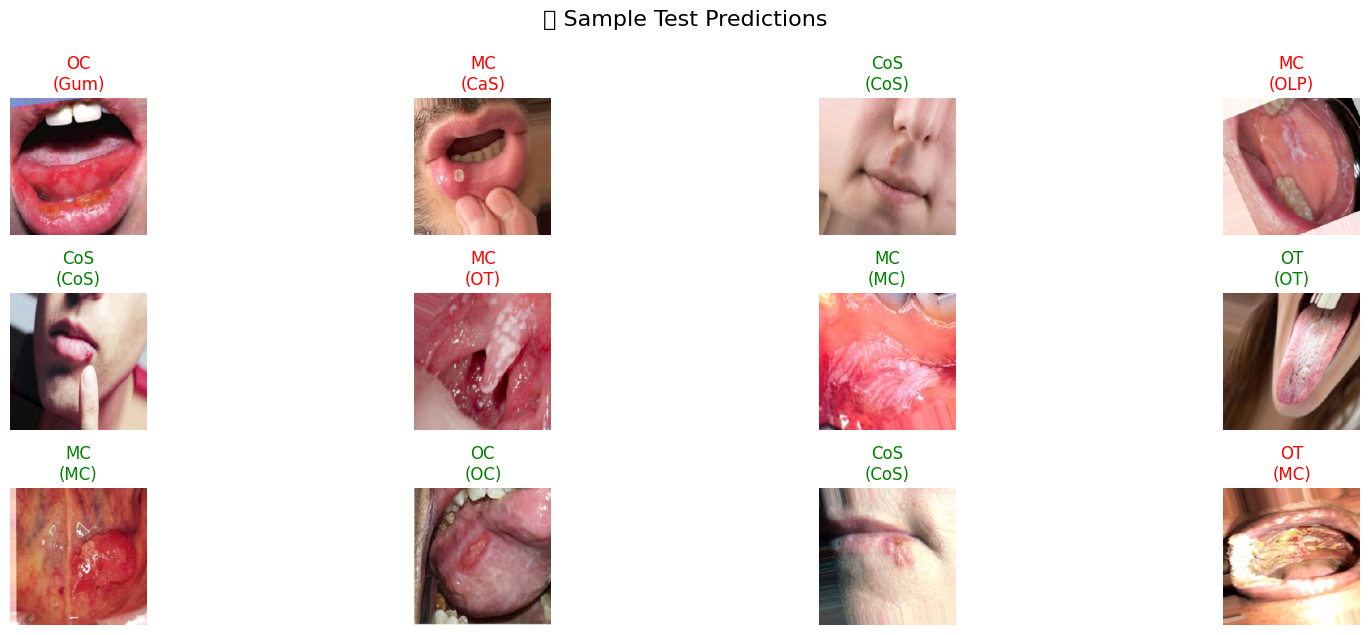



🧠 Evaluating Model 2: EfficientNetB0 (Pretrained)
📂 Loaded weights from: results/EfficientNetB0_Pretrained.pt



📊 Classification Report:
              precision    recall  f1-score   support

         CaS       1.00      1.00      1.00       160
         CoS       1.00      1.00      1.00       149
         Gum       1.00      1.00      1.00       120
          MC       0.99      0.99      0.99       180
          OC       0.99      0.98      0.99       108
         OLP       1.00      1.00      1.00       180
          OT       1.00      1.00      1.00       131

    accuracy                           1.00      1028
   macro avg       1.00      1.00      1.00      1028
weighted avg       1.00      1.00      1.00      1028


📊 Evaluation Metrics for EfficientNetB0 (Pretrained):
  Accuracy : 99.71%
  Precision: 99.71%
  Recall   : 99.71%
  F1 Score : 99.71%

🧪 Full Test Evaluation
❌ Total wrong predictions: 3/1028

🔍 Listing all 3 misclassified samples:
  ⛔ Sample 147: Predicted MC ❌ instead of OC
  ⛔ Sample 829: Predicted MC ❌ instead of OC
  ⛔ Sample 992: Predicted OC ❌ instead of MC


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.



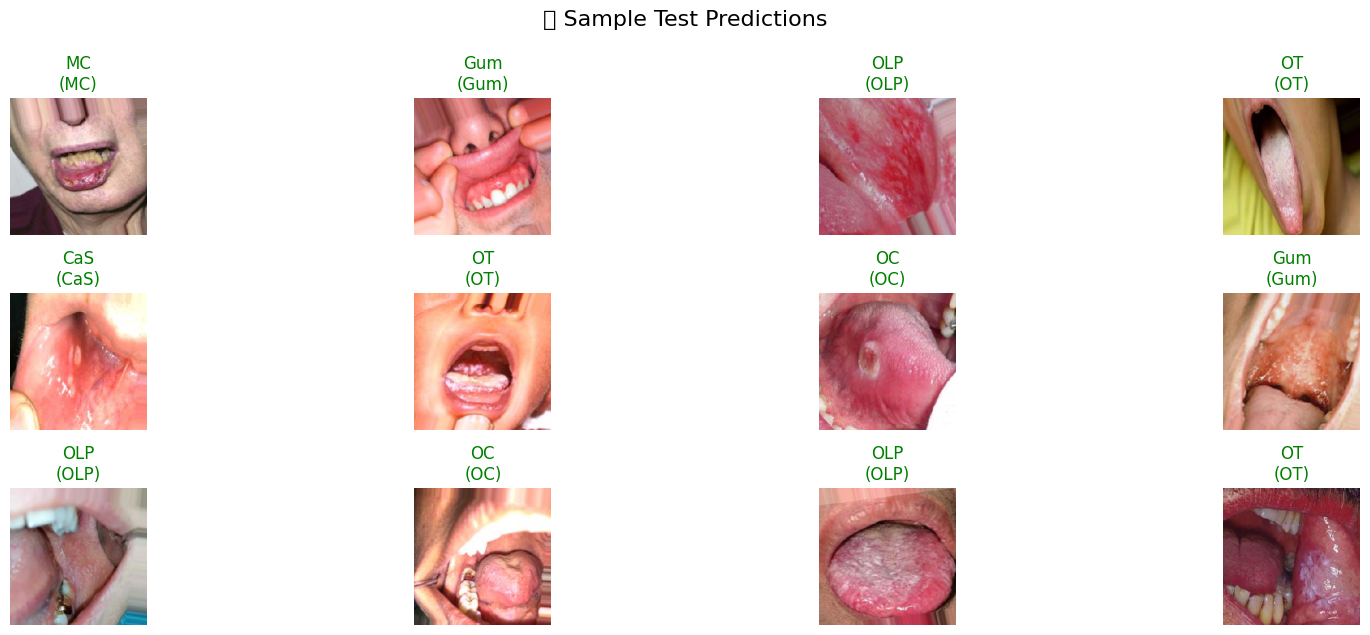



🧠 Evaluating Model 3: EfficientNetB0 (Scratch)
📂 Loaded weights from: results/EfficientNetB0_Scratch.pt



📊 Classification Report:
              precision    recall  f1-score   support

         CaS       0.64      0.55      0.59       160
         CoS       0.78      0.80      0.79       149
         Gum       0.69      0.53      0.60       120
          MC       0.49      0.54      0.51       180
          OC       0.34      0.47      0.40       108
         OLP       0.51      0.44      0.47       180
          OT       0.46      0.50      0.48       131

    accuracy                           0.55      1028
   macro avg       0.56      0.55      0.55      1028
weighted avg       0.56      0.55      0.55      1028


📊 Evaluation Metrics for EfficientNetB0 (Scratch):
  Accuracy : 54.86%
  Precision: 56.34%
  Recall   : 54.86%
  F1 Score : 55.23%

🧪 Full Test Evaluation
❌ Total wrong predictions: 464/1028

🔍 Listing all 464 misclassified samples:
  ⛔ Sample 2: Predicted Gum ❌ instead of MC
  ⛔ Sample 3: Predicted OT ❌ instead of Gum
  ⛔ Sample 4: Predicted OLP ❌ instead of MC
  ⛔ Sample 

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.



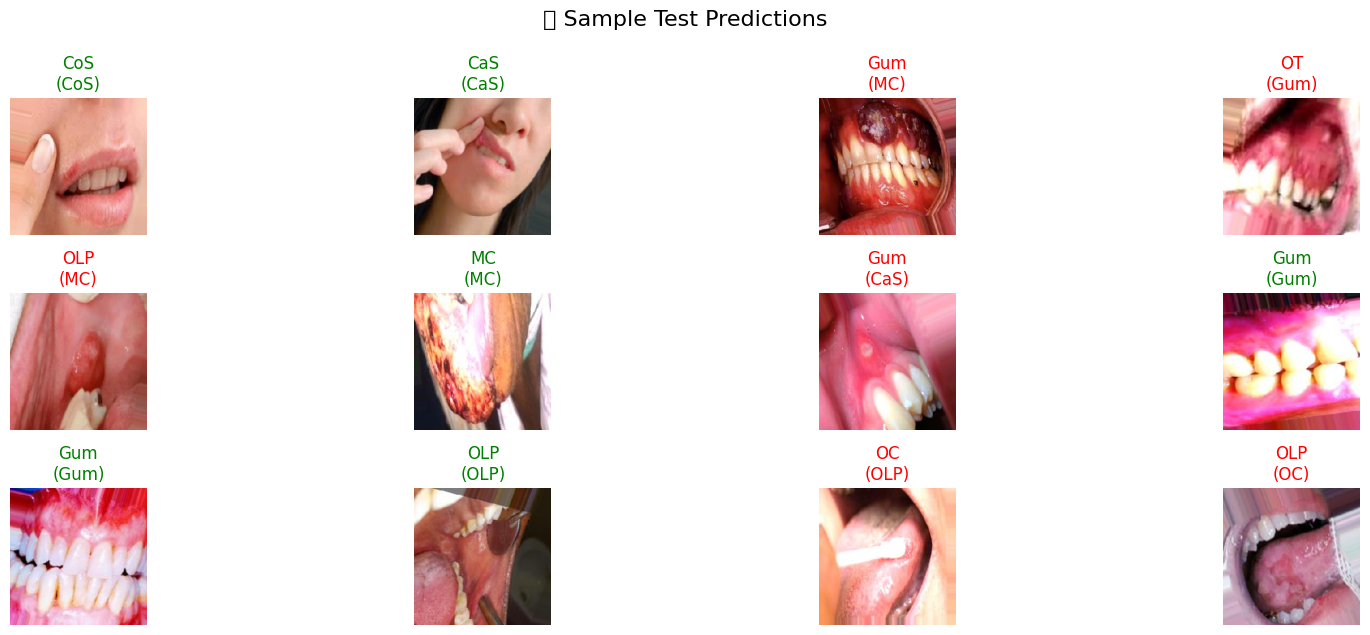



🧠 Evaluating Model 4: ResNet18 (Pretrained)
📂 Loaded weights from: results/ResNet18_Pretrained.pt



📊 Classification Report:
              precision    recall  f1-score   support

         CaS       0.99      0.99      0.99       160
         CoS       1.00      1.00      1.00       149
         Gum       0.98      1.00      0.99       120
          MC       0.98      0.99      0.99       180
          OC       0.98      0.96      0.97       108
         OLP       0.99      0.98      0.99       180
          OT       0.99      1.00      1.00       131

    accuracy                           0.99      1028
   macro avg       0.99      0.99      0.99      1028
weighted avg       0.99      0.99      0.99      1028


📊 Evaluation Metrics for ResNet18 (Pretrained):
  Accuracy : 98.83%
  Precision: 98.84%
  Recall   : 98.83%
  F1 Score : 98.83%

🧪 Full Test Evaluation
❌ Total wrong predictions: 12/1028

🔍 Listing all 12 misclassified samples:
  ⛔ Sample 112: Predicted CaS ❌ instead of OLP
  ⛔ Sample 244: Predicted MC ❌ instead of OC
  ⛔ Sample 296: Predicted Gum ❌ instead of CaS
  ⛔ Sampl

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.



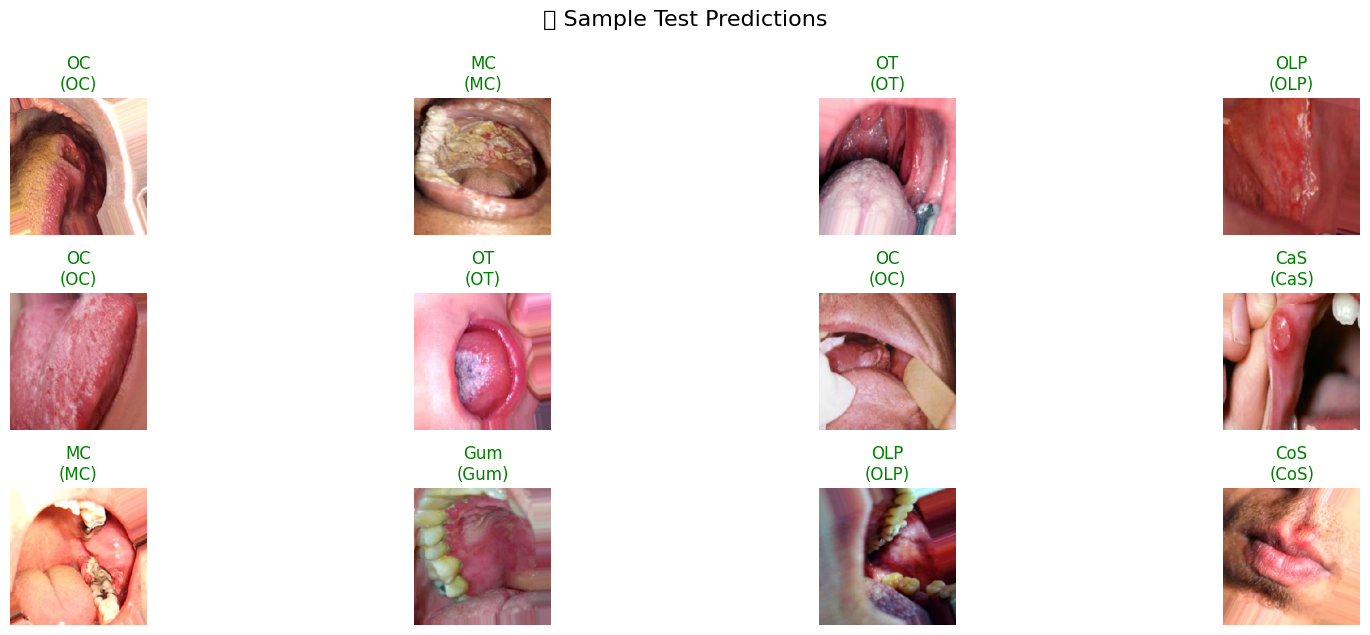



🧠 Evaluating Model 5: ResNet18 (Scratch)
📂 Loaded weights from: results/ResNet18_Scratch.pt



📊 Classification Report:
              precision    recall  f1-score   support

         CaS       0.84      0.69      0.76       160
         CoS       0.83      0.97      0.89       149
         Gum       0.85      0.72      0.78       120
          MC       0.63      0.82      0.71       180
          OC       0.68      0.63      0.65       108
         OLP       0.71      0.65      0.68       180
          OT       0.78      0.73      0.75       131

    accuracy                           0.75      1028
   macro avg       0.76      0.74      0.75      1028
weighted avg       0.76      0.75      0.75      1028


📊 Evaluation Metrics for ResNet18 (Scratch):
  Accuracy : 74.81%
  Precision: 75.63%
  Recall   : 74.81%
  F1 Score : 74.69%

🧪 Full Test Evaluation
❌ Total wrong predictions: 259/1028

🔍 Listing all 259 misclassified samples:
  ⛔ Sample 1: Predicted CaS ❌ instead of Gum
  ⛔ Sample 3: Predicted OC ❌ instead of CaS
  ⛔ Sample 6: Predicted CaS ❌ instead of Gum
  ⛔ Sample 7: P

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.



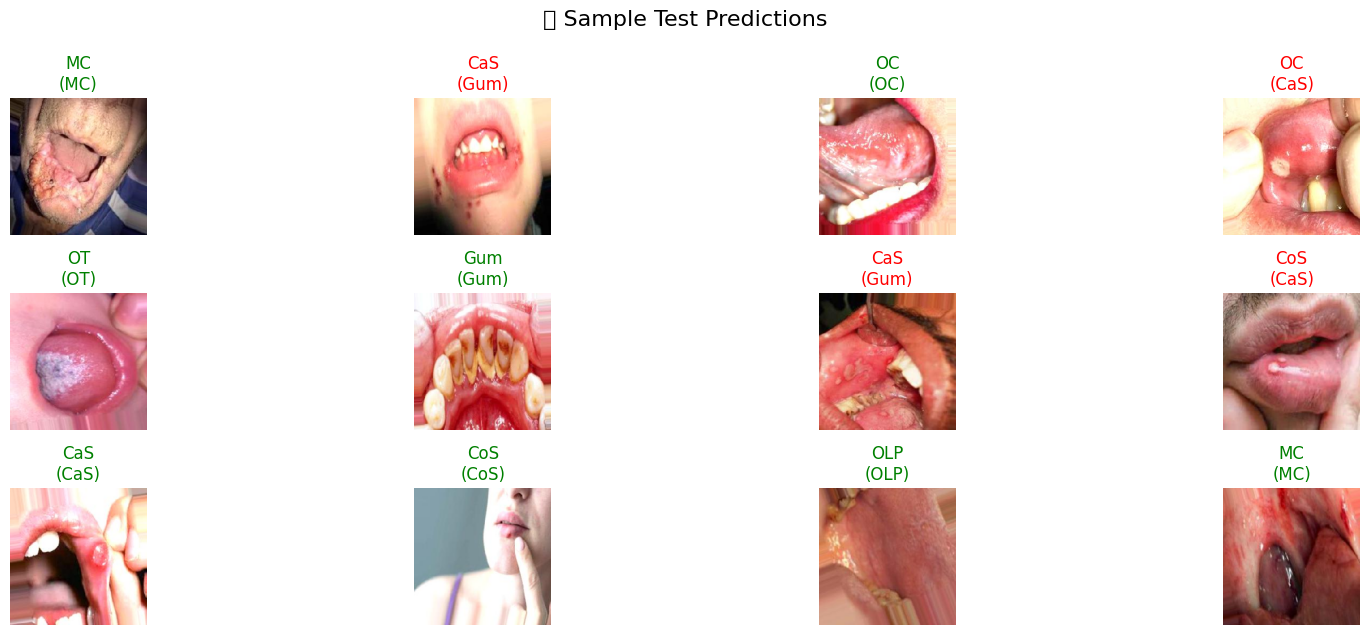

In [40]:
for i, row in df.iterrows():
    model_name = row["Model"].replace(" ", "_").replace("(", "").replace(")", "")
    pt_path = f"results/{model_name}.pt"
    history_path = f"results/{model_name}_history.json"

    # Match model class
    ModelClass = MODEL_CLASSES[i]
    model = ModelClass(num_classes=NUM_CLASSES).to(DEVICE)
    model.load_state_dict(torch.load(pt_path))
    model.eval()

    print(f"\n\n🧠 Evaluating Model {i+1}: {row['Model']}")
    print("📂 Loaded weights from:", pt_path)

    # Load and plot training history
    if os.path.exists(history_path):
        with open(history_path, "r") as f:
            history = json.load(f)
        plot_loss_accuracy(history, model_name)
    else:
        print("❌ No training history file found!")

    # Evaluate all metrics
    metrics = evaluate_all_metrics(model, test_loader)
    print(f"\n📊 Evaluation Metrics for {row['Model']}:")
    print(f"  Accuracy : {metrics['accuracy']*100:.2f}%")
    print(f"  Precision: {metrics['precision']*100:.2f}%")
    print(f"  Recall   : {metrics['recall']*100:.2f}%")
    print(f"  F1 Score : {metrics['f1']*100:.2f}%")

    # Visualize test predictions
    visualize_test_predictions(model, test_loader, num_samples=SAMPLES_TO_VISUALIZE)

In [41]:
def compare_model_sizes(results_dir="results", summary_csv="model_comparison.csv"):
    csv_path = os.path.join(results_dir, summary_csv)

    # 🛡️ Make sure the CSV exists (or create a fresh one with model names only)
    if not os.path.exists(csv_path):
        print(f"⚠️ {csv_path} not found. Creating a basic summary...")
        model_files = [f for f in os.listdir(results_dir) if f.endswith(".pt")]
        data = [{"Model": f.replace(".pt", ""), "Model Path": f} for f in model_files]
        df = pd.DataFrame(data)
    else:
        df = pd.read_csv(csv_path)

    # 🔍 Measure file sizes
    sizes_mb = []
    for i, row in df.iterrows():
        model_file = os.path.join(results_dir, row["Model Path"])
        if os.path.exists(model_file):
            size_bytes = os.path.getsize(model_file)
            size_mb = size_bytes / (1024 * 1024)
            sizes_mb.append(round(size_mb, 2))
        else:
            sizes_mb.append(None)
            print(f"❌ File not found: {model_file}")

    df["Model Size (MB)"] = sizes_mb
    df.to_csv(csv_path, index=False)
    print(f"\n📦 Model sizes added to: {csv_path}")
    return df

In [42]:
df = compare_model_sizes("results")
df[["Model", "Model Size (MB)", "Test Accuracy", "Train Time (s)", "Inference Time (s)"]]


📦 Model sizes added to: results/model_comparison.csv


Model  Model Size (MB)  Test Accuracy  \
0                      BaseCNN           189.15          60.51   
1  EfficientNetB0 (Pretrained)            15.62          99.71   
2     EfficientNetB0 (Scratch)            15.61          54.86   
3        ResNet18 (Pretrained)            42.73          98.83   
4           ResNet18 (Scratch)            42.73          74.81   

   Train Time (s)  Inference Time (s)  
0          139.93                0.73  
1          343.66                1.42  
2          341.77                1.44  
3          220.34                1.08  
4          220.35                1.09

In [43]:
def plot_model_sizes(df):
    fig = px.bar(df, x="Model", y="Model Size (MB)", color="Model",
                 title="📦 Model Size Comparison (MB)",
                 template="plotly_dark", text="Model Size (MB)")
    fig.update_layout(title_x=0.5, yaxis_title="Size (MB)")
    fig.show()

plot_model_sizes(df)

In [44]:
fig = px.scatter(df, x="Model Size (MB)", y="Test Accuracy", color="Model",
                 text="Model", title="🎯 Accuracy vs Model Size",
                 template="plotly_dark")
fig.update_traces(textposition='top center')
fig.update_layout(title_x=0.5)
fig.show()


In [45]:
!zip -r /kaggle/working/results.zip /kaggle/working/results

updating: kaggle/working/results/ (stored 0%)
updating: kaggle/working/results/🌀_ResNet18_Pretrained.onnx (deflated 7%)
updating: kaggle/working/results/🧠_BaseCNN_history.json (deflated 59%)
updating: kaggle/working/results/🧱_EfficientNetB0_Scratch.pt (deflated 8%)
updating: kaggle/working/results/🌀_ResNet18_Pretrained_history.json (deflated 65%)
updating: kaggle/working/results/🧩_ResNet18_Scratch_history.json (deflated 59%)
updating: kaggle/working/results/🧠_BaseCNN.pt (deflated 8%)
updating: kaggle/working/results/🚀_EfficientNetB0_Pretrained_history.json (deflated 64%)
updating: kaggle/working/results/🧠_BaseCNN.onnx (deflated 8%)
updating: kaggle/working/results/🚀_EfficientNetB0_Pretrained.onnx (deflated 7%)
updating: kaggle/working/results/🌀_ResNet18_Pretrained.pt (deflated 7%)
updating: kaggle/working/results/🧱_EfficientNetB0_Scratch.onnx (deflated 8%)
updating: kaggle/working/results/🧩_ResNet18_Scratch.pt (deflated 7%)
updating: kaggle/working/results/🧱_EfficientNetB0_Scratch_hist

In [46]:
!zip -r /kaggle/working/processed_data.zip /kaggle/working/processed_data

updating: kaggle/working/processed_data/ (stored 0%)
updating: kaggle/working/processed_data/train .npz (deflated 0%)
updating: kaggle/working/processed_data/val.npz (deflated 2%)
updating: kaggle/working/processed_data/test.npz (deflated 2%)
